In [2]:
#from helpers import *
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast
import matplotlib.cm as cm
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go


In [5]:
file_source = "/Users/dorahborgi/Documents/GitHub/ada-2024-project-theadavengers/"


predictions_gpt_df = pd.read_csv(file_source+'Prediction csv files/movies_gpt2_prediction.csv')
predictions_gpt_df = predictions_gpt_df.rename(columns={'feminism':"prediction_gpt"})
predictions_SVM_df = pd.read_csv(file_source+'Prediction csv files/movies_svm_predictions.csv')
predictions_SVM_df = predictions_SVM_df.rename(columns={'Feminism prediction':"prediction_svm"})
columns_to_keep = ['Wikipedia movie ID', 'prediction_svm']
predictions_SVM_df = predictions_SVM_df[columns_to_keep]


In [6]:
predictions_df = pd.merge(predictions_gpt_df, predictions_SVM_df, left_on='Wikipedia movie ID',right_on='Wikipedia movie ID', how='outer')
predictions_df.loc[predictions_df['prediction_svm'].isna(), 'prediction_svm'] = 1

In [7]:
predictions_df['is_equal'] = predictions_df['prediction_svm'] == predictions_df['prediction_gpt']

In [8]:
test = predictions_df[predictions_df['is_equal']==False]
test.shape

(15057, 18)

In [9]:
def extract_year(date_str):
        if pd.isna(date_str):  # Check if the value is NaN
            return None  # Return None or a suitable placeholder for NaN
        if len(date_str) == 4:  # Check if it's a four-digit year
            return int(date_str)  # Return the year as an integer
        return pd.to_datetime(date_str, errors='coerce').year  # Convert to datetime and extract year


    # Extract the year without modifying the original column
predictions_df['Year'] = predictions_df['Movie release date'].apply(extract_year)

In [10]:
predictions_df.to_csv('predictions_df.csv', index=False)

In [11]:
predictions_df.columns

Index(['Unnamed: 0', 'Wikipedia movie ID', 'Summaries', 'Freebase movie ID',
       'Movie name', 'Movie release date', 'Movie box office revenue',
       'Movie runtime', 'Movie languages (Freebase ID:name tuples)',
       'Movie countries (Freebase ID:name tuples)',
       'Movie genres (Freebase ID:name tuples)', 'Year',
       'Country dictionnaire', 'Genre dictionnaire', 'Language dictionnaire',
       'prediction_gpt', 'prediction_svm', 'is_equal'],
      dtype='object')

# Nombre de films qui réussissent le test par an

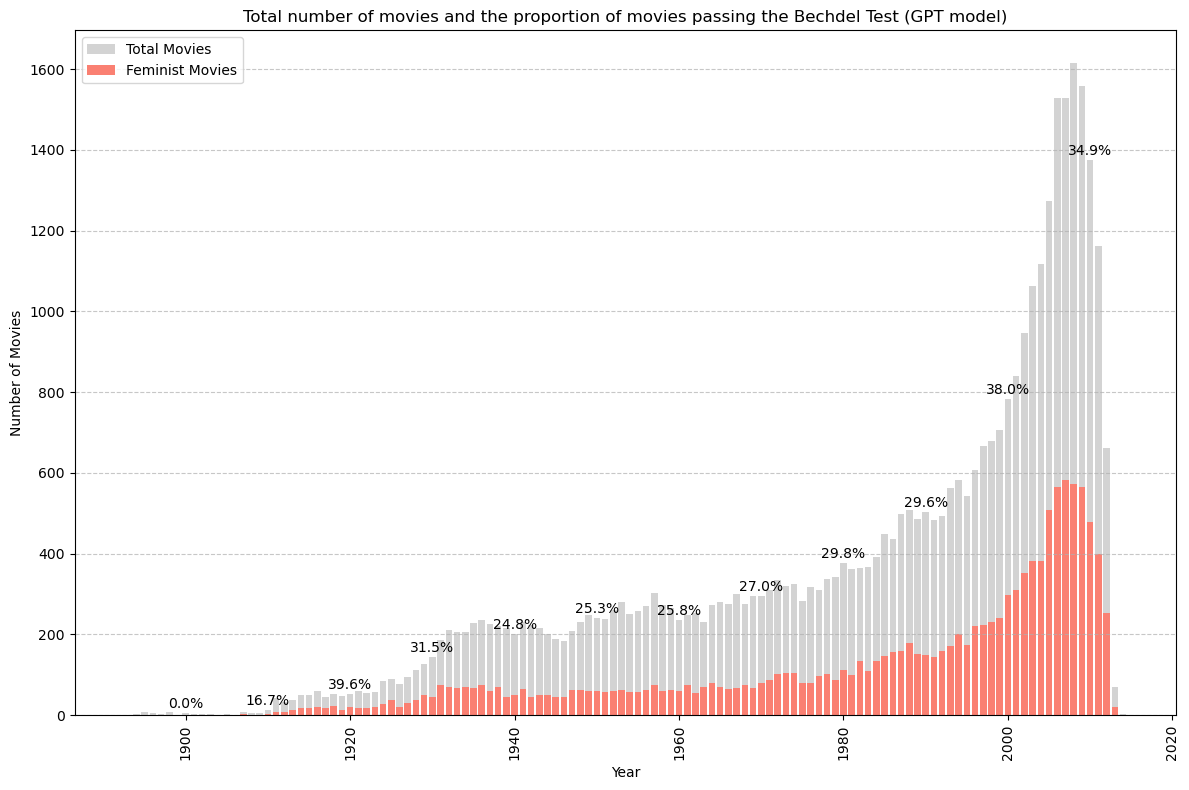

In [12]:
# Count the total number of movies per year
count_per_year_all = predictions_df.groupby('Year').size().reset_index(name='total_movies')

# Count the number of feminist movies per year
feminist_count_gpt = predictions_df[predictions_df['prediction_gpt'] == True]
count_per_year_gpt = feminist_count_gpt.groupby('Year').size().reset_index(name='feminist_movies')

# Merge the two counts on 'Year'
merged_counts = pd.merge(count_per_year_all, count_per_year_gpt, on='Year', how='left')

# Fill missing values with 0 (if no feminist movies are present for that year)
merged_counts['feminist_movies'] = merged_counts['feminist_movies'].fillna(0)

# Calculate the percentage of feminist movies
merged_counts['feminist_percentage'] = merged_counts['feminist_movies'] / merged_counts['total_movies'] * 100

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(merged_counts['Year'], merged_counts['total_movies'], color='lightgray', label='Total Movies')

# Plot the feminist movies on top (stacked)
ax.bar(merged_counts['Year'], merged_counts['feminist_movies'], color='salmon', label='Feminist Movies')

# Labeling
ax.set_xlabel('Year')
ax.set_ylabel('Number of Movies')
ax.set_title('Total number of movies and the proportion of movies passing the Bechdel Test (GPT model)')

# Show the percentage of feminist movies on top of the bars every 10 years
for i, row in merged_counts.iterrows():
    if row['Year'] % 10 == 0:  # Show only every 10 years
        ax.text(row['Year'], row['total_movies'] + 5, f"{row['feminist_percentage']:.1f}%", ha='center', va='bottom')

# Add grid and legend
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend()

# Ajustement des ticks et affichage
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()

# Sauvegarder dans une variable pour le nommer
plot1 = fig

# Montrer le plot
plt.show()


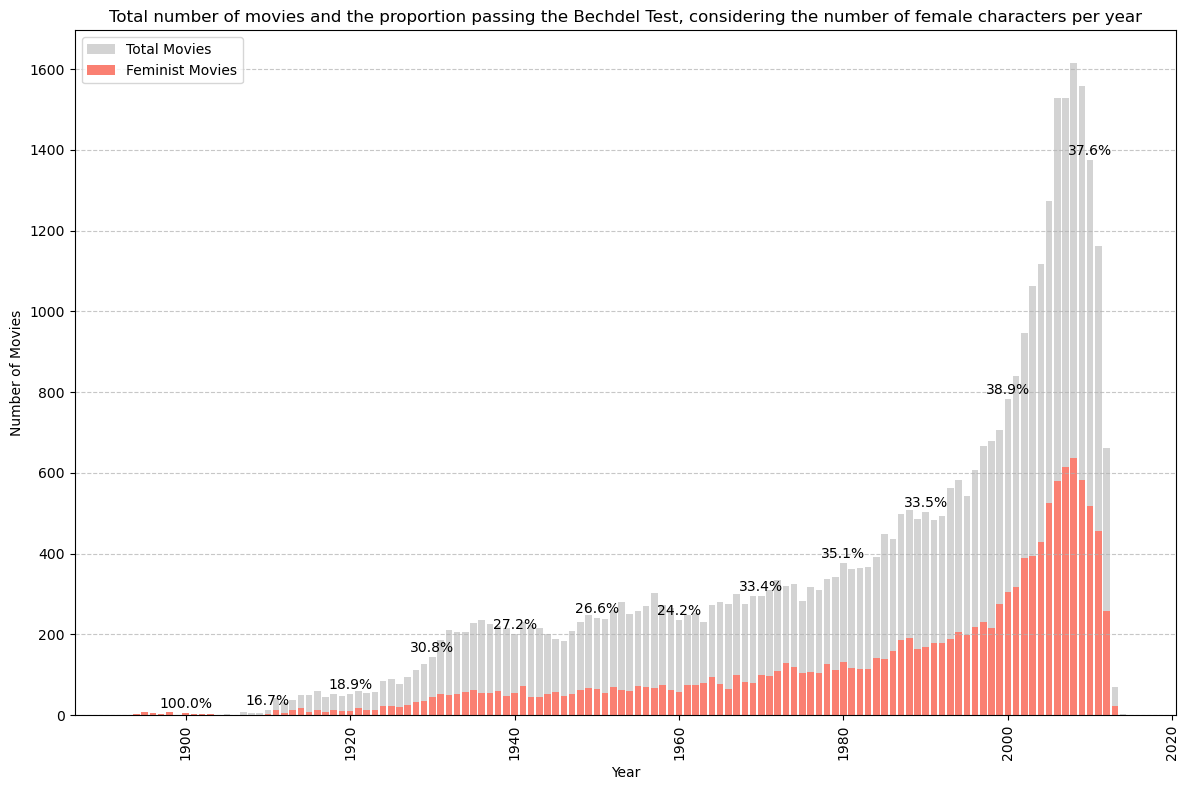

In [13]:
import mpld3

# Count the number of feminist movies per year
feminist_count_svm = predictions_df[predictions_df['prediction_svm'] == True]
count_per_year_svm = feminist_count_svm.groupby('Year').size().reset_index(name='feminist_movies')

# Merge the two counts on 'Year'
merged_counts = pd.merge(count_per_year_all, count_per_year_svm, on='Year', how='left')

# Fill missing values with 0 (if no feminist movies are present for that year)
merged_counts['feminist_movies'] = merged_counts['feminist_movies'].fillna(0)

# Calculate the percentage of feminist movies
merged_counts['feminist_percentage'] = merged_counts['feminist_movies'] / merged_counts['total_movies'] * 100


fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(merged_counts['Year'], merged_counts['total_movies'], color='lightgray', label='Total Movies')

ax.bar(merged_counts['Year'], merged_counts['feminist_movies'], color='salmon', label='Feminist Movies')

ax.set_xlabel('Year')
ax.set_ylabel('Number of Movies')
ax.set_title('Total number of movies and the proportion passing the Bechdel Test, considering the number of female characters per year')

# Show the percentage of feminist movies on top of the bars every 10 years
for i, row in merged_counts.iterrows():
    if row['Year'] % 10 == 0:  # Show only every 10 years
        ax.text(row['Year'], row['total_movies'] + 5, f"{row['feminist_percentage']:.1f}%", ha='center', va='bottom')

ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()

plot2 = fig

# Montrer le plot
plt.show()

mpld3.save_html(fig, 'plot.html')

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=merged_counts['Year'],
    y=merged_counts['total_movies'],
    name='Total Movies',
    marker_color='lightgray'
))


fig.add_trace(go.Bar(
    x=merged_counts['Year'],
    y=merged_counts['feminist_movies'],
    name='Feminist Movies',
    marker_color='salmon'
))


for i, row in merged_counts.iterrows():
    if row['Year'] % 10 == 0:  
        fig.add_annotation(
            x=row['Year'],
            y=row['total_movies'] + 5,
            text=f"{row['feminist_percentage']:.1f}%",
            showarrow=False,
            font=dict(size=12),
            align='center'
        )

# Update layout for better appearance
fig.update_layout(
    title="Total and Feminist Movies per Year",
    xaxis_title="Year",
    yaxis_title="Number of Movies",
    barmode='group',
    template='plotly_white',
    xaxis=dict(tickangle=90),
    legend_title="Movie Type"
)

fig.write_html('feminist_movies_interactive2.html')

fig.show()

# Pourcentage de films qui réussissent le test de Beschdel selon le pays

In [14]:
predictions_df['Country dictionnaire'] = predictions_df['Movie countries (Freebase ID:name tuples)'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

predictions_df['Genre dictionnaire'] = predictions_df['Movie genres (Freebase ID:name tuples)'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

predictions_explode_country = predictions_df.explode('Country dictionnaire')

predictions_explode_country['passes_bechdel_svm'] = predictions_explode_country['prediction_svm']
predictions_explode_country['passes_bechdel_gpt'] = predictions_explode_country['prediction_gpt']


grouped_svm = predictions_explode_country.groupby(['Country dictionnaire', 'Year']).agg(
    total_movies=('Wikipedia movie ID', 'count'),
    feminist_movies=('passes_bechdel_svm', 'sum')  # Somme des valeurs True
).reset_index()

grouped_gpt = predictions_explode_country.groupby(['Country dictionnaire', 'Year']).agg(
    total_movies=('Wikipedia movie ID', 'count'),
    feminist_movies=('passes_bechdel_gpt', 'sum')  # Somme des valeurs True
).reset_index()

In [15]:
films_per_country = predictions_explode_country.groupby('Country dictionnaire').size().reset_index(name='total_movies')
top_5_countries = films_per_country.sort_values(by='total_movies', ascending=False).head(5)
top_countries_name = ['United States of America', "India", 'United Kingdom', 'France', 'Italy']

print(top_5_countries)

    Country dictionnaire  total_movies
118            /m/09c7w0         20788
53              /m/03rk0          4751
106             /m/07ssc          4036
130            /m/0f8l9c          2296
127            /m/0d060g          1491


In [16]:
grouped_svm['feminist_percentage'] = grouped_svm['feminist_movies'] / grouped_svm['total_movies'] * 100
grouped_gpt['feminist_percentage'] = grouped_gpt['feminist_movies'] / grouped_gpt['total_movies'] * 100


In [17]:
grouped_gpt = grouped_gpt[(grouped_gpt['Year'] >= 1960) & (grouped_gpt['Year'] < 2008)]
grouped_svm = grouped_svm[(grouped_svm['Year'] >= 1960) & (grouped_svm['Year'] < 2008)]

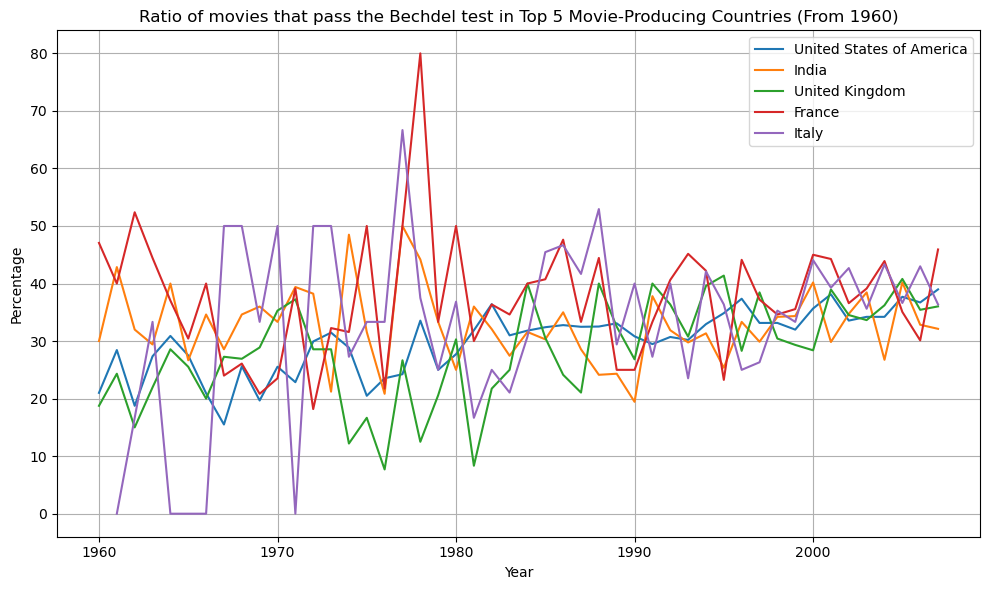

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, country in enumerate(top_5_countries['Country dictionnaire']):
    country_data = grouped_gpt[grouped_gpt['Country dictionnaire'] == country]
    ax.plot(country_data['Year'], country_data['feminist_percentage'], label=f'{top_countries_name[i]}')

ax.set_title('Ratio of movies that pass the Bechdel test in Top 5 Movie-Producing Countries (From 1960)')
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:


fig = go.Figure()
for i, country in enumerate(top_5_countries['Country dictionnaire']):
    country_data = grouped_gpt[grouped_gpt['Country dictionnaire'] == country]
    fig.add_trace(go.Scatter(
        x=country_data['Year'],
        y=country_data['feminist_percentage'],
        mode='lines',
        name=top_countries_name[i],  # Utilise le label du pays
        hovertemplate=f"<b>{top_countries_name[i]}</b><br>Year: {{x}}<br>Percentage: {{y:.2f}}%"  # Format interactif
    ))

fig.update_layout(
    title="Ratio of Movies That Pass the Bechdel Test in Top 5 Movie-Producing Countries (From 1960)",
    xaxis_title="Year",
    yaxis_title="Percentage",
    legend_title="Country",
    template="plotly_white",
    hovermode="x unified" 
)

html_file = "bechdel_test_ratio_per_country_GPT.html"
fig.write_html(html_file)

fig.show()


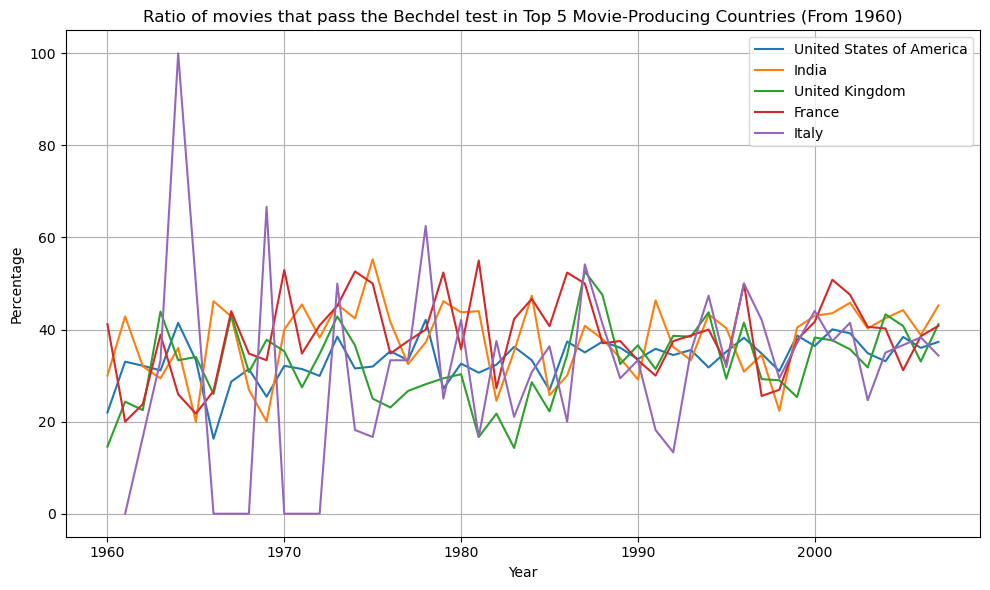

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, country in enumerate(top_5_countries['Country dictionnaire']):
    country_data = grouped_svm[grouped_svm['Country dictionnaire'] == country]
    ax.plot(country_data['Year'], country_data['feminist_percentage'], label=f'{top_countries_name[i]}')

ax.set_title('Ratio of movies that pass the Bechdel test in Top 5 Movie-Producing Countries (From 1960)')
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [34]:
fig = go.Figure()
for i, country in enumerate(top_5_countries['Country dictionnaire']):
    country_data = grouped_svm[grouped_svm['Country dictionnaire'] == country]
    fig.add_trace(go.Scatter(
        x=country_data['Year'],
        y=country_data['feminist_percentage'],
        mode='lines',
        name=top_countries_name[i],  # Utilise le label du pays
        hovertemplate=f"<b>{top_countries_name[i]}</b><br>Year: {{x}}<br>Percentage: {{y:.2f}}%"  # Format interactif
    ))

fig.update_layout(
    title="Ratio of Movies That Pass the Bechdel Test in Top 5 Movie-Producing Countries (From 1960)",
    xaxis_title="Year",
    yaxis_title="Percentage",
    legend_title="Country",
    template="plotly_white",
    hovermode="x unified" 
)

html_file = "bechdel_test_ratio_per_country_SVM.html"
fig.write_html(html_file)

fig.show()

# Pourcentage de films qui réussissent le test selon le genre

In [20]:
genres_grouped = {
    "Action and Adventure": [
        'Action', 'Action Thrillers', 'Action/Adventure', 'Adventure', 'Action Thriller', 'Adventure Comedy', 'Superhero', 
        'Superhero movie', 'War film', 'War effort', 'Sci-Fi Adventure', 'Sword and sorcery', 'Sword and sorcery films', 
        'Martial Arts Film', 'Heist', 'Combat Films', 'Western', 'B-Western', 'Spaghetti Western', 'Crime Thriller', 
        'Detective fiction', 'Spy', 'Spy Film', 'Action Thrillers'
    ],
    "Drama": [
        'Drama', 'Period piece', 'Family Drama', 'Romantic drama', 'Tragicomedy', 'Courtroom Drama', 
        'Political drama', 'Medical fiction', 'Crime Drama', 'Historical drama', 'Legal drama', 'Political satire', 
        'Inspirational Drama', 'Courtroom Comedy', 'Historical Epic', 'Family-Oriented Adventure', 
        'Social problem film', 'Nature', 'Domestic Comedy', 'Juvenile Delinquency Film', 'Coming of age', 'Childhood Drama',
        'Family & Personal Relationships', 'Americana', 'Roadshow theatrical release', 'Culture & Society', 'Interpersonal Relationships',
        'Teen', 'Addiction Drama',  'Marriage Drama', 'Slice of life story', 
    ],
    "Comedy": [
        'Comedy', 'Screwball comedy', 'Satire', 'Black comedy', 'Romantic comedy', 'Comedy-drama', 
        'Slapstick', 'Comedy Thriller', 'Domestic Comedy', 'Parody', 'Dark Comedy', 'Stand-up comedy', 
        'Slapstick Comedy', 'Comedy film', 'Black-and-white Comedy', 'Comedy of manners', 'Ensemble Film',
        'Comedy of Errors', 'Humour', 'Comedy Western', 'Workplace Comedy', 'Action Comedy', 'Ealing Comedies', 'Mockumentary'
    ],
    "Horror and Thriller": [
        'Horror', 'Thriller', 'Slasher', 'Psychological thriller', 'Zombie Film', 'Supernatural', 
        'Monster movie', 'Crime Thriller', 'Horror Comedy', 'Gothic Film', 'Horror Mystery', 'Psychological horror', 
        'Slasher film', 'Crime Fiction', 'Psycho-biddy', 'Vampire movies', 'Erotic thriller', 'Natural horror films',
        'Comedy horror', 'Costume Horror'
    ],
    "Romance": [
        'Romance Film', 'Romantic fantasy', 'Romantic drama', 'Romantic comedy', 'Love story', 
        'Romantic thriller', 'Fantasy Romance', 'Sex comedy', 'Christmas movie'
    ],
    "Sci-Fi and Fantasy": [
        'Science Fiction', 'Fantasy', 'Fantasy Comedy', 'Sci-Fi Horror', 'Space western', 'Cyberpunk', 'Dystopia', 
        'Alien Film', 'Supernatural', 'Time travel', 'Apocalyptic and post-apocalyptic fiction', 'Steampunk',
        'Fantasy Adventure', 'Neo-noir', 'Surrealism', 'Sci-Fi Thriller', 'Sci Fi Pictures original films'
    ],
    "Family and Kids": [
        'Family Film', 'Animated', 'Children\'s/Family', 'Family-Oriented Adventure', 'Animation', 'Children\'s Fantasy',
        'Animated Musical', 'Family Movie', 'Fairy tale', "Children's", 'Animated cartoon', 'School story', "Children's Issues", 
        "Children's Entertainment", "Children's Film",  'Family-Oriented films', 'Family',
        "Children's Issue"
    ],
    "Documentary": [
        'Documentary', 'Docudrama', 'Biography', 'Educational', 'Music', 'Travel', 'Social issues', 
        'Politics & Society', 'Environmental Science', 'Business', 'Political cinema', 'Historical Documentaries',
        'Health & Fitness', 'World History'
    ],
    "Indie": [
        'Indie', 'Experimental film', 'Avant-garde', 'Art film', 'Independent film', 'Mumblecore', 'Film-Opera', 'Short Film',
        'Experimental Films', 'Psychological Films'
    ],
    "History": [
        'History', 'Historical fiction', 'Biographical film', 'Historical epic', 'Costume drama', 'Historical drama',
        'Biographical film', 'War and Politics', 'WWII Films', 'Political cinema', 'Period Horror'
    ],
    "Cult": [
        'Cult','B-movie','Grindhouse','Blaxploitation','Giallo','Zombie Film','Stoner film','Erotic film','Exploitation film',
        'Pinku eiga', 'Splatter film', 'Gore', 'Erotica', 'Softcore Porn', 'Pornographic movie', 'Hardcore pornography',
        'Gay pornography', 'Gay', 'Gay Interest', 'Erotic Drama', 'Exploitation', 'Glamorized Spy Film', 'Gay Themed'
    ],
    "Crime and Mystery": [
        'Crime Fiction', 'Crime Drama', 'Detective', 'Film noir', 'Mystery', 'Whodunit', 'Crime Comedy', 'Caper story',
        'Legal Drama', 'Crime Thriller', 'Gangster Film', 'Heist', 'Crime', 'Glamorized Spy Film'
    ],
    "Social Issues and Political Films": [
        'Political drama', 'Political satire', 'Political thriller', 'Social issue films', 'Law & Crime', 
        'Gender Issues', 'Political cinema', 'Propaganda film'
    ],
    "Experimental": [
        'Experimental Films', 'Psychological Films', 'Crime Comedy', 'Propaganda Films', 'Sexploitation', 
        'Supernatural Film', 'Detective Fiction', 'Cult Films', 'Anthropology', 'Mondo film', 'Public Domain', 
        'Genre Fiction', 'Bloopers & Candid Camera', 'Screwball comedy', 'Comedy horror'
    ],
    #"Feminist Films": [
    #    'Feminist Film', 'Gender Issues', 'Women in prison films', 'Women’s Studies', 'Feminist cinema', 
    #    'Women in film', 'Feminist documentary', 'Sexual Politics in Film'
    #],
    "Musical":['Musical', 'Bollywood', 'Musical Drama', 'Hip hop movies', 'Jukebox musical','Punk rock',
               'Backstage Musical', 'Instrumental Music', 'Operetta', 'Punk rock'

    ],
    "Miscellaneous Other Genres": [
        'World cinema', 'Black-and-white', 'Biopic [feature]', 'Film adaptation', 
        'Musical comedy', 'Beach Film', 'Silent film', 'Melodrama', 'Television movie', 
        'Sports', 'LGBT', 'Filipino', 'Filipino Movies', 'Epic', 'Anthology', 'Japanese Movies', 
        'Haunted House Film', 'Tamil cinema', 'The Netherlands in World War II', 'Suspense', 'Erotic comedy', 
        'Tollywood', 'New Hollywood', 'Erotic Drama', 'Erotica', 'Chinese Movies', 
        'Fantasy Drama', 'Pre-Code', 'Neo-noir', 'Buddy film', 'Kitchen sink realism', 'Media Satire', 
        'Computer Animation', 'Christian film', 'Creature Film', 'Remake'
        'Road movie', 'Boxing', 'Stop motion', 'Holiday Film', 'Animal Picture', 'Feature film', 
        'Dogme 95', 'Gross out', 'Road-Horror', 'Disaster', 
        'Natural disaster', 'Anime', 'Chase Movie', 'Escape Film', 'Dance', 
        'Religious Film', 'Samurai cinema', 'Tragedy', 'Monster', 
        'Absurdism', 'British Empire Film', 'Costume Adventure', 'Biker Film', 'Film à clef', 
        'Horse racing', 'Wuxia', 'Heavenly Comedy', 'Cavalry Film', 'Anti-war', 
        'Doomsday film', 'Swashbuckler films', 'Comedy Western', 'Revisionist Western','Archaeology', 'Albino bias', 'Pornography', 'Science fiction Western', 'Hybrid Western', 
        'Exploitation', 'British New Wave', 'Foreign legion', 'Illnesses & Disabilities', 
        'Coming-of-age film', 'Heaven-Can-Wait Fantasies', 'Race movie', 'Movie serial', 'Indian Western', 
        'Bengali Cinema', 'News', 'Czechoslovak New Wave', 'Sponsored film', 'Sword and Sandal', 'Mythological Fantasy', 
        'Roadshow/Carny', 'Fictional film', 'Filmed Play', 'Z movie', 'Parkour in popular culture', 'Essay Film', 
        'Latino', 'Animals', 'Media Studies', 'Prison', 'Goat gland', 'Future noir', 'Auto racing', 'Fan film', 
        'Early Black Cinema', 'Existentialism', 'Airplanes and airports',
        'Revisionist Western', 'Archaeology', 'Albino bias', 'Pornography', 'Gay pornography', 
        'Science fiction Western', 'Hybrid Western', 'Exploitation', 'British New Wave', 'Foreign legion', 
        'Illnesses & Disabilities', 'Coming-of-age film', 'Heaven-Can-Wait Fantasies', 'Race movie', 'Movie serial', 
        'Indian Western', 'Bengali Cinema', 'Gross-out film', 'Adult', 'Remake', 'Road movie', 'Rockumentary', 'Anti-war film',
       'Hagiography', 'Female buddy film', 'Language & Literature',
       'Malayalam Cinema', 'Extreme Sports', 'Jungle Film', 'Film',
       'Film & Television History', 'Prison film', 'Epic Western',
       'Beach Party film', 'Werewolf fiction', 'Archives and records',
       'Acid western', 'Outlaw', 'Northern', 'Supermarionation',
       'Demonic child', 'Kafkaesque', 'Clay animation', 'Concert film',
       'Finance & Investing', 'Bruceploitation', 'Graphic & Applied Arts',
       'Live action', 'Computers', 'Plague', 'Education',
       'Therimin music', 'Libraries and librarians', 'Expressionism',
       'Cold War', 'Point of view shot', 'Buddy cop',
       'Inventions & Innovations', 'Star vehicle', 'New Queer Cinema',
       'Camp', 'Master Criminal Films', 'Comdedy', 'Statutory rape',
       'Alien invasion', 'Journalism', 'Reboot', 'Feminist Film', 'Gender Issues', 'Women in prison films', 'Women’s Studies', 'Feminist cinema', 
        'Women in film', 'Feminist documentary', 'Sexual Politics in Film'
    ]
}


In [21]:
import json

# Function to preprocess genre column
def extract_genres(genre_str):
    try:
        # Convert the genre string (which is in JSON format) to a dictionary
        genre_dict = json.loads(genre_str)
        # Extract genre names from the dictionary (the values)
        genres = list(genre_dict.values())
        return genres
    except Exception as e:
        # In case of an error in parsing, return an empty list or handle the error appropriately
        return []

In [22]:
predictions_df['genres'] = predictions_df['Movie genres (Freebase ID:name tuples)'].apply(extract_genres)

genre_to_group = {}
for group, genres_list in genres_grouped.items():
    for genre in genres_list:
        genre_to_group[genre] = group

def categorize_genre(genre):
    return genre_to_group.get(genre, 'Other')

predictions_explode_genre = predictions_df.explode('genres')

predictions_explode_genre['genre_general'] = predictions_explode_genre['genres'].apply(categorize_genre)



In [23]:
predictions_explode_genre.columns

Index(['Unnamed: 0', 'Wikipedia movie ID', 'Summaries', 'Freebase movie ID',
       'Movie name', 'Movie release date', 'Movie box office revenue',
       'Movie runtime', 'Movie languages (Freebase ID:name tuples)',
       'Movie countries (Freebase ID:name tuples)',
       'Movie genres (Freebase ID:name tuples)', 'Year',
       'Country dictionnaire', 'Genre dictionnaire', 'Language dictionnaire',
       'prediction_gpt', 'prediction_svm', 'is_equal', 'genres',
       'genre_general'],
      dtype='object')

In [24]:
movies_per_genre = predictions_explode_genre.groupby(['Year', 'genre_general']).agg(
    pred_gpt = ('prediction_gpt', 'sum'),
    pred_svm = ('prediction_svm', 'sum'),
    nb_total = ('Wikipedia movie ID', 'count')
)

In [25]:
movies_per_genre['percentage_gpt']= movies_per_genre['pred_gpt']/movies_per_genre['nb_total']

movies_per_genre['percentage_svm']= movies_per_genre['pred_svm']/movies_per_genre['nb_total']

In [41]:
movies_per_genre = movies_per_genre.loc[
    (movies_per_genre.index.get_level_values('Year') >= 1940) &
    (movies_per_genre.index.get_level_values('Year') < 2008)
]

/var/folders/dl/y_0dp4yd3sd1cf5mnxcnpt100000gn/T/ipykernel_22199/3809224033.py:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



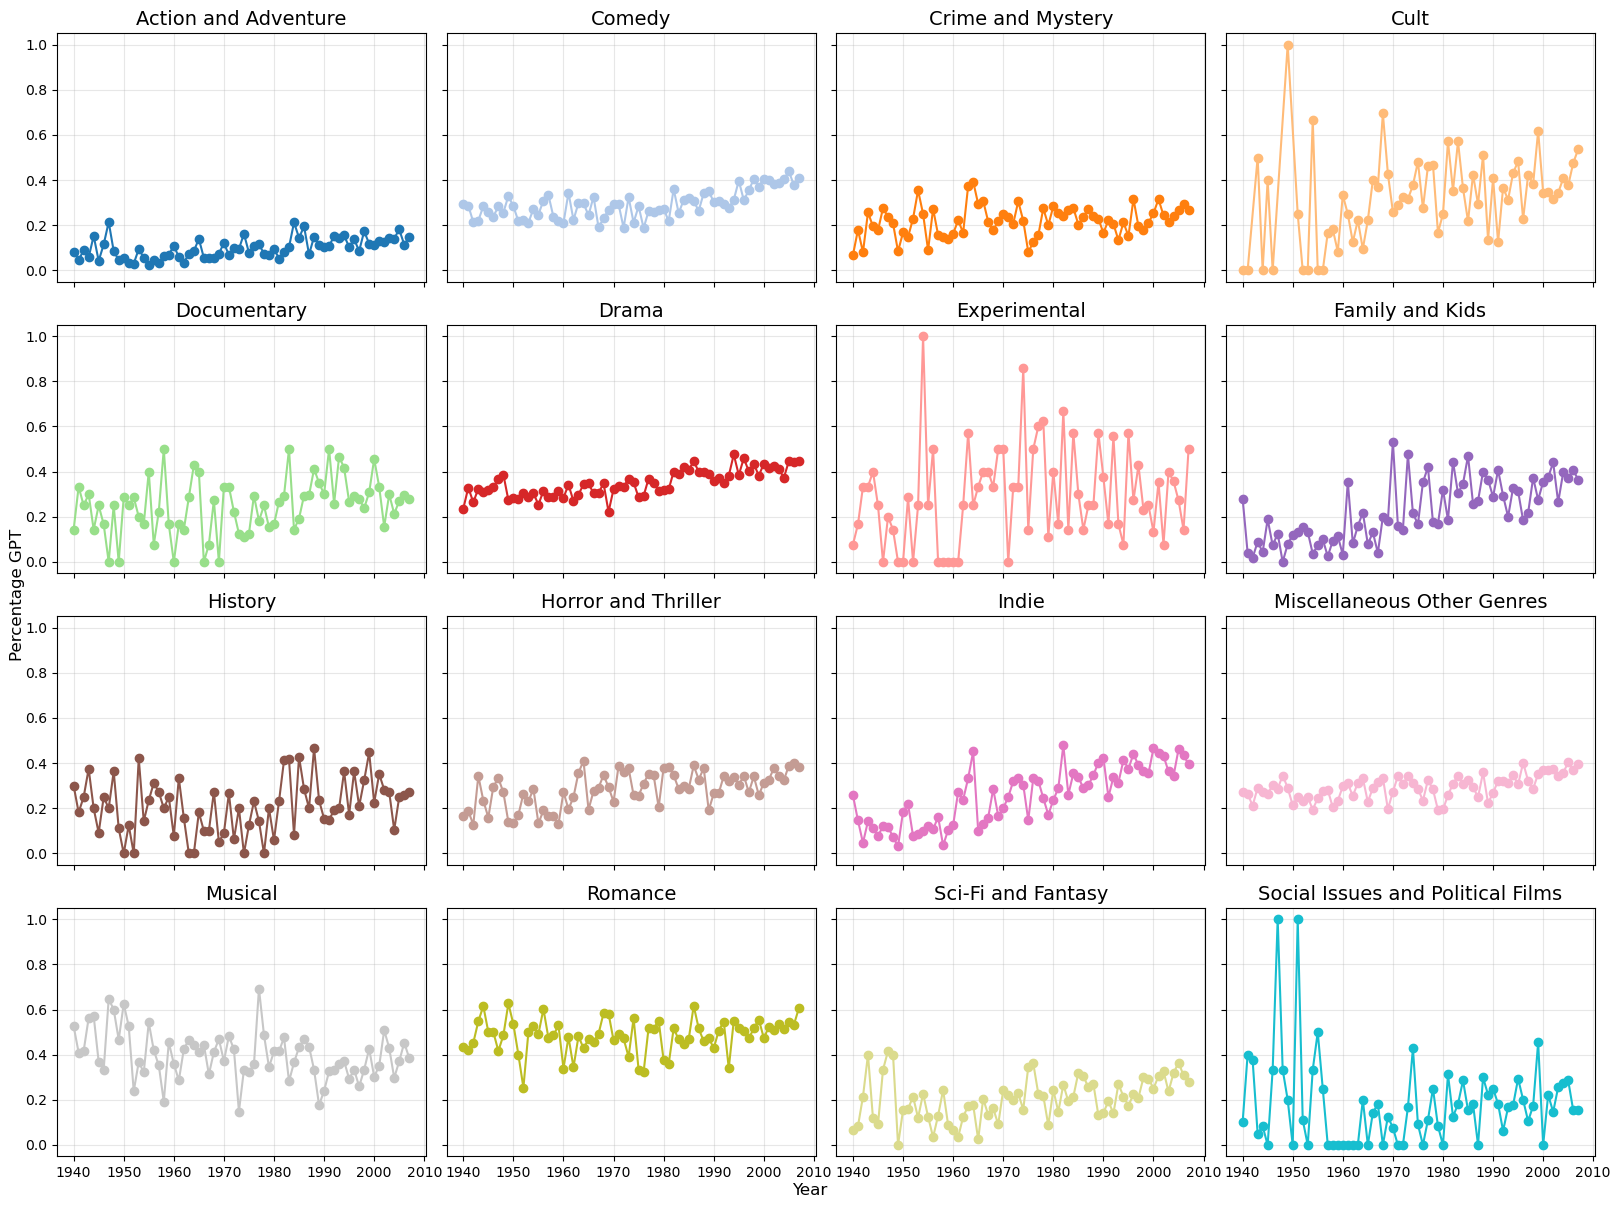

In [53]:
unique_genres = movies_per_genre.index.get_level_values('genre_general').unique()

colormap = cm.get_cmap('tab20', len(unique_genres))

fig, axes = plt.subplots(4, 4, figsize=(16, 12), sharey=True, sharex=True)

genre_colors = {genre: colormap(i) for i, genre in enumerate(unique_genres)}

title_fontsize = 14

for ax, genre in zip(axes.ravel(), unique_genres):
    genre_data = movies_per_genre.xs(genre, level='genre_general')
    
    ax.plot(genre_data.index, genre_data['percentage_gpt'], marker='o', label=f"{genre}", color=genre_colors[genre])
    
    ax.set_title(genre, fontsize=title_fontsize)  # Taille ajustée ici
    ax.grid(alpha=0.3)

for ax in axes.ravel()[len(unique_genres):]:
    ax.axis('off')

fig.text(0.5, 0, 'Year', ha='center', fontsize=12)
fig.text(0, 0.5, 'Percentage GPT', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()

output_file = "percentage_gpt_per_genre.png"
fig.savefig(output_file, format='png', dpi=300)  # dpi=300 pour une qualité élevée
plt.show()

In [55]:

for ax, genre in zip(axes.ravel(), unique_genres):
    genre_data = movies_per_genre.xs(genre, level='genre_general')
    
    ax.plot(genre_data.index, genre_data['percentage_svm'], marker='o', label=f"{genre}", color=genre_colors[genre])
    
    ax.set_title(genre, fontsize=title_fontsize) 
    ax.grid(alpha=0.3)

for ax in axes.ravel()[len(unique_genres):]:
    ax.axis('off')

fig.text(0.5, 0, 'Year', ha='center', fontsize=12)
fig.text(0, 0.5, 'Percentage SVM', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()

output_file = "percentage_svm_per_genre.png"
fig.savefig(output_file, format='png', dpi=300)

plt.show()

<Figure size 640x480 with 0 Axes>

# Proportion of Movies that pass the test Bechdel in the Box Office

float64


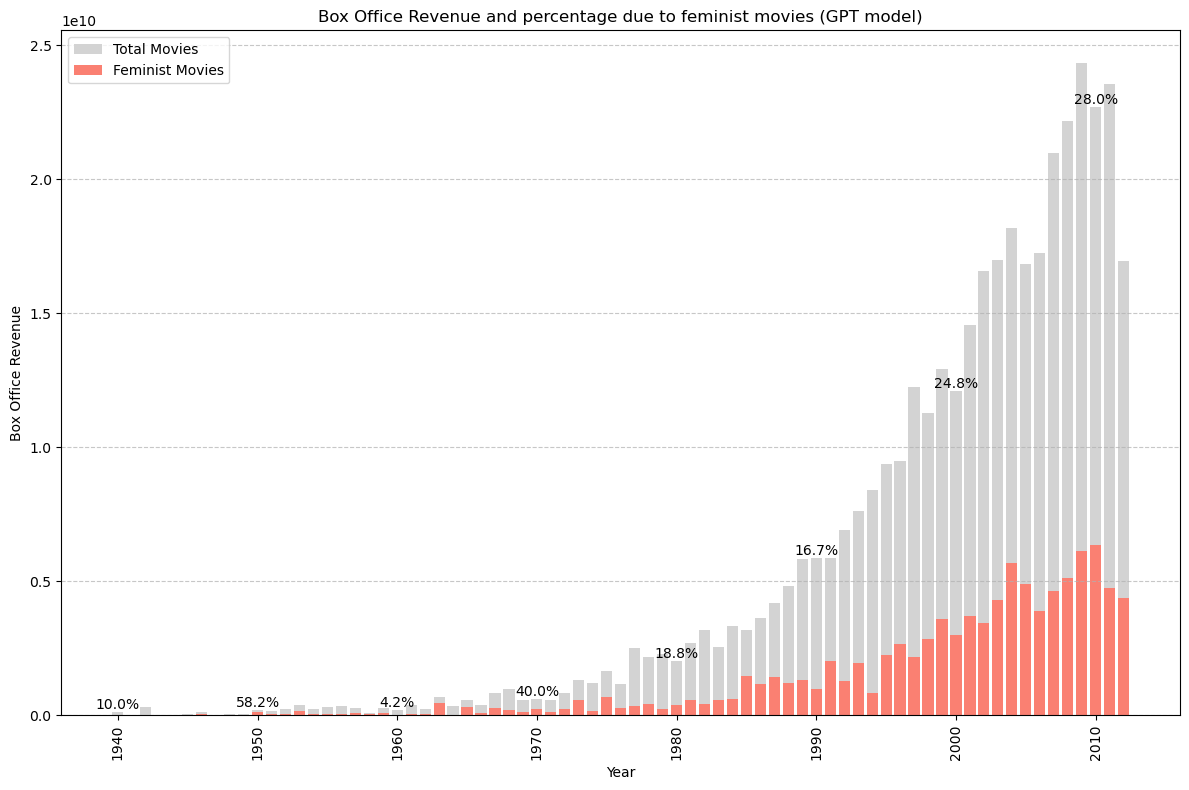

In [45]:
GPT_BOX = predictions_df[['Year','Wikipedia movie ID', 'prediction_gpt', 'Movie box office revenue']].sort_values('Year')

gpt_revenue_year = GPT_BOX.groupby('Year').agg(
    box_office_total = ('Movie box office revenue', 'sum'),
    box_office_fem=('Movie box office revenue', lambda x: x[GPT_BOX['prediction_gpt'] == 1].sum())
)
gpt_revenue_year['ratio'] = 100*gpt_revenue_year['box_office_fem'].div(gpt_revenue_year['box_office_total'])

print(gpt_revenue_year.index.dtype)
gpt_revenue_year = gpt_revenue_year['1940':'2013']

plt.figure(figsize=(12, 8))

plt.bar(gpt_revenue_year.index, gpt_revenue_year['box_office_total'], color='lightgray', label='Total Movies')

plt.bar(gpt_revenue_year.index, gpt_revenue_year['box_office_fem'], color='salmon', label='Feminist Movies')

plt.xlabel('Year')
plt.ylabel('Box Office Revenue')
plt.title('Box Office Revenue and percentage due to feminist movies (GPT model)')

for year, row in gpt_revenue_year.iterrows():  # 'year' corresponds to the index (Year) in the DataFrame
    if int(year) % 10 == 0:  # Ensure the index (year) is treated as an integer
        plt.text(
            year,  # The x-coordinate is the year (from the index)
            row['box_office_total'] + 5,  # The y-coordinate is just above the total bar
            f"{row['ratio']:.1f}%",  # The annotation text
            ha='center', va='bottom'
        )

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()


plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()


In [64]:
import plotly.graph_objects as go
import pandas as pd

fig = go.Figure()

fig.add_trace(go.Bar(
    x=gpt_revenue_year.index, 
    y=gpt_revenue_year['box_office_total'], 
    name='Total Movies',
    marker_color='lightgray'
))

fig.add_trace(go.Bar(
    x=gpt_revenue_year.index, 
    y=gpt_revenue_year['box_office_fem'], 
    name='Feminist Movies',
    marker_color='salmon'
))

for year, row in gpt_revenue_year.iterrows():
    if int(year) % 10 == 0: 
        fig.add_annotation(
            x=year,
            y=row['box_office_total'],
            text=f"{row['ratio']:.1f}%",
            showarrow=False,
            font=dict(size=10),
            align="center"
        )

# Ajuster le layout
fig.update_layout(
    title='Box Office Revenue and Percentage due to Feminist Movies (GPT model)',
    xaxis_title='Year',
    yaxis_title='Box Office Revenue',
    barmode='overlay',
    legend_title='Categories',
    template='plotly_white',
    xaxis=dict(tickangle=90),
    margin=dict(l=40, r=40, t=80, b=40),
    height=600
)

fig.write_html("box_office_revenue_gpt.html")

fig.show()


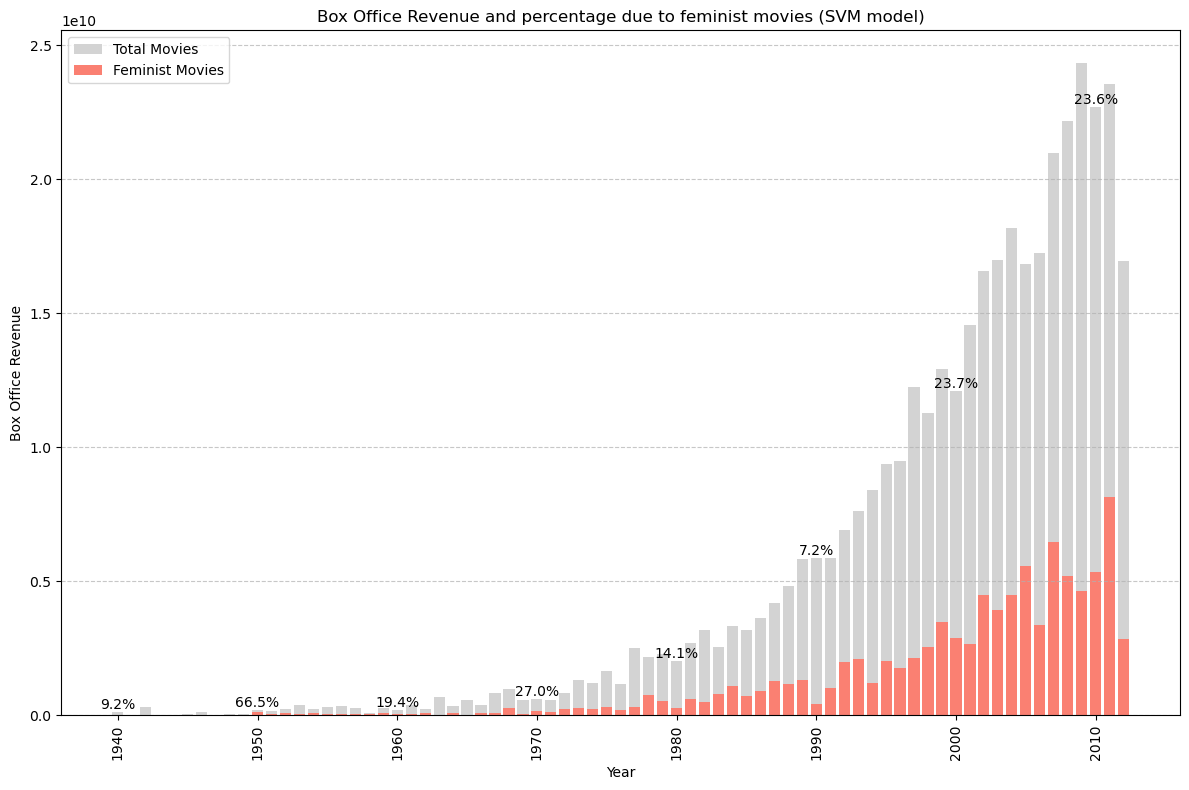

In [61]:
SVM_BOX = predictions_df[['Year','Wikipedia movie ID', 'prediction_svm', 'Movie box office revenue']].sort_values('Year')

svm_revenue_year = SVM_BOX.groupby('Year').agg(
    box_office_total = ('Movie box office revenue', 'sum'),
    box_office_fem=('Movie box office revenue', lambda x: x[SVM_BOX['prediction_svm'] == 1].sum())
)
svm_revenue_year['ratio'] = 100*svm_revenue_year['box_office_fem'].div(svm_revenue_year['box_office_total'])

svm_revenue_year = svm_revenue_year['1940':'2013']


# Plotting the stacked bar chart
plt.figure(figsize=(12, 8))

# Plot the overall number of movies
plt.bar(svm_revenue_year.index, svm_revenue_year['box_office_total'], color='lightgray', label='Total Movies')

# Plot the feminist movies on top (stacked)
plt.bar(svm_revenue_year.index, svm_revenue_year['box_office_fem'], color='salmon', label='Feminist Movies')

# Labeling
plt.xlabel('Year')
plt.ylabel('Box Office Revenue')
plt.title('Box Office Revenue and percentage due to feminist movies (SVM model)')

# Show the percentage of feminist movies on top of the bars every 10 years
for year, row in svm_revenue_year.iterrows():  # 'year' corresponds to the index (Year) in the DataFrame
    if int(year) % 10 == 0:  # Ensure the index (year) is treated as an integer
        plt.text(
            year,  # The x-coordinate is the year (from the index)
            row['box_office_total'] + 5,  # The y-coordinate is just above the total bar
            f"{row['ratio']:.1f}%",  # The annotation text
            ha='center', va='bottom'
        )

# Add grid and legend
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Display the plot
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(
    x=svm_revenue_year.index, 
    y=svm_revenue_year['box_office_total'], 
    name='Total Movies',
    marker_color='lightgray'
))

fig.add_trace(go.Bar(
    x=svm_revenue_year.index, 
    y=svm_revenue_year['box_office_fem'], 
    name='Feminist Movies',
    marker_color='salmon'
))

for year, row in svm_revenue_year.iterrows():
    if int(year) % 10 == 0: 
        fig.add_annotation(
            x=year,
            y=row['box_office_total'],
            text=f"{row['ratio']:.1f}%",
            showarrow=False,
            font=dict(size=10),
            align="center"
        )

fig.update_layout(
    title='Box Office Revenue and Percentage due to Feminist Movies (SVM model)',
    xaxis_title='Year',
    yaxis_title='Box Office Revenue',
    barmode='overlay',
    legend_title='Categories',
    template='plotly_white',
    xaxis=dict(tickangle=90),
    margin=dict(l=40, r=40, t=80, b=40),
    height=600
)

fig.write_html("box_office_revenue_svm.html")

fig.show()


# Pourcentage de films oscarisés qui vérifient le test de Bechdel 

In [47]:
oscars_df = pd.read_csv(file_source + 'Prediction csv files/oscars_df.csv')
columns_to_keep = ['Film', 'Award', 'IMDB Rating']
oscars_df = oscars_df[columns_to_keep]

In [48]:
# Films oscarisés et nominés 
oscars_percentage = pd.merge(predictions_df, oscars_df, left_on = 'Movie name', right_on = 'Film', how='inner')

In [49]:
columns_to_keep = ['Movie name','prediction_gpt', 'prediction_svm', 'Award']
oscars_percentage = oscars_percentage[columns_to_keep]

In [ ]:
from dash import Dash, dcc, html, Input, Output
import io
import base64


def calculate_percentage(df, model_col, award_type):
    if award_type == "Nominee":
        relevant_df = df[df['Award'].isin(['Winner', 'Nominee'])]
    else:
        relevant_df = df[df['Award'] == award_type]

    total = len(relevant_df)
    passing = len(relevant_df[relevant_df[model_col] == 1])
    failing = total - passing

    return passing, failing

def generate_pie_chart(df, model_col):
    data_winner = calculate_percentage(df, model_col, "Winner")
    data_nominee = calculate_percentage(df, model_col, "Nominee")

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].pie(
        data_winner,
        labels=['Pass', 'Fail'],
        autopct='%1.1f%%',
        startangle=140,
        colors=['lightgreen', '#ff9999']
    )
    axes[0].set_title("Winners")

    axes[1].pie(
        data_nominee,
        labels=['Pass', 'Fail'],
        autopct='%1.1f%%',
        startangle=140,
        colors=['lightgreen', '#ff9999']
    )
    axes[1].set_title("Nominees")

    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    plt.close(fig)

    return base64.b64encode(buf.getvalue()).decode('utf-8')

app = Dash(__name__)

app.layout = html.Div([
    html.H1("Bechdel Test Pie Charts", style={'textAlign': 'center'}),

    html.Div(id="pie-chart-container"),

    html.Div([
        html.Label("Select Bechdel Test Model:"),
        dcc.Dropdown(
            id="model-dropdown",
            options=[
                {"label": "GPT Prediction", "value": "prediction_gpt"},
                {"label": "SVM Prediction", "value": "prediction_svm"},
            ],
            value="prediction_gpt", 
            clearable=False
        ),
    ], style={"width": "50%", "margin": "auto", "margin-top": "20px"}),  # Ajout d'un espacement avec margin-top
])

@app.callback(
    Output("pie-chart-container", "children"),
    [Input("model-dropdown", "value")]
)
def update_charts(selected_model):
    img_base64 = generate_pie_chart(oscars_percentage, selected_model)
    return html.Img(src=f"data:image/png;base64,{img_base64}", style={"width": "100%"})

if __name__ == "__main__":
    app.run_server(debug=True, port='8051')